In [3]:
suppressPackageStartupMessages({
    library(sna)
    library(testthat)
    library(network)
    library(ergm)
})

# Overview

This tutorial has two main parts

* Modelling diffusion/contagion from time-stamped data, and
* Modelling social influence in cross-sectional data

# Diffusion and contagion
We are considering spread on a static network, spread of the kind that once you are 'infected' you stay infected, whether this be by an idea or a disease.

## Small worlds
Think of stylised network where everyone has the same degree but where there are not redundant ties that create cycles. In such a network, a person can reach an additional $d^k$ unique others at each step, as in the left-hand panel. Should some ties be re-wired to close open triads, the number of nodes the focal actor can reach is reduced significantly as in the right-hand panel.

![Reach in random network and reach in clustered network.](growth.png)

What implications does this have for diffusion on networks where we have clustering as opposed to random Bernoulli networks?

## Web resources
Some realy good tutorials on <https://kateto.net/network-visualization> and, also, a nice online simulator for ERGM at <https://michaellevy.shinyapps.io/gwdegree/>.

## Basic setup
We are going to assume that there is a static network, $X$, and that, in continuous time, nodes in the network may become 'infected' by their neighbours. We model the state of all of the nodes by a binary vector $Y$, where at time $t$, $Y(t)$ is 
* equal to 1, if the nodes has adopted the innovation/become infected, and
* equal to 0 otherwise

## Time to adoption
What we want to model is the *time until adoption*, the time, given the state of the system, at which point a node $i$ goes from $Y_i(t)=0$ to $Y(t+\delta)=1$. A basic component in this is the *rate of change* - if someone has a higher rate of change, they are likely to change more quickly that if they have a low rate of change.

We are now going to look at different ways in which we can let the rate of a person $i$ changing be dependent on the adoption status of $i$'s neighbours.

# Define functions

Greenan (2015) provides a review of different diffusion models in the survival-analysis framework.

Define the survival model time-till-infected. We assume that the time $t$ until you get infected, given that you are suceptible, is exponential with rate
$$
\lambda_i(Y(t_0),X(t_0)) = \exp\left\{ \alpha +\beta a_i( x(t_0),y(t_0) ) \right\}
$$
In the sequel we drop the notational dependence on time and write $a_i(y(t),x(t))= a_i(y,x) $. 

### Non-network influence
Myers (2000)  proposed the rate be modelled as
$$
a_i(y,x) = \sum_jy_js_j(x)
$$
where $s_j(x)$ is the importance of $j$, a function that may be network dependent. This could for example be centrality, as in  Strang and Tuma (1993). Transmission or diffusion does not take place on the edges of the graph here.

### Diffusion on network ties
A general formulation could be
$$
a_i(y,x) = \sum_jy_j x_{ij} s_j(x)
$$
where only actors that $i$ has a tie to affect the rate but different actors $j$ may be unequal in their importance as measured by $s_j(x)$

Based on Valente (2005), Greenan (2015) defines **average exposure** as
$$
a_i(y,x) = \frac{\sum_j y_j x_{ij}}{\max\{ \sum_j x_{ij},1 \}}
$$

so that the higher proportion of contacts that have adopted, the higher the risk of $i$ adopting. Note that the risks/rates with be identical for a person with one alter that has adopted as for a person with $k$ alters, all of whom have adopted.

In order to allow for the number of adopters you have ties to to affect the rate,Greenan (2015)  also define **total exposure**
$$
a_i(y,x) = \sum_j y_j x_{ij}
$$

Myers (2000) and Strang and Tuma (1993) introduce the idea of accounting for the actors *susceptibility* or  *responsiveness*, $p_i(x)$. This can be interacted with any of the exposure and influence effects, for example with total exposure
$$
a_i(y,x) = p_i(x)\sum_j y_j x_{ij}
$$

## Time-to-adoption

The time $T_i$ (from $t_0$) until $i$ gets infected is the exponentially distributed $T_i \thicksim Exp(\lambda_i(Y(t_0),X(t_0)) )$, which implies that the probability that $i$ is the next one to become infected is
$$
\frac{\lambda_i(Y(t_0),X(t_0))}{\sum_{j \in V: Y(t_0)=0} \lambda_i(Y(t_0),X(t_0))}
$$

By the properties of the exponential distribution, we also have that
$$
T_{min}=\min \{T_1, \ldots , T_n \} \thicksim Exp \left( \sum_{ j \in V: Y(t_0)=0 } \lambda_i(Y(t_0),X(t_0) ) \right)
$$


These models are *piece-wise constant* or *proportional hazard* models - the rate of change, or eagerness to adopt, only is altered when the system changes.

## Diffusion function
We will write a function calculates the rate


In [4]:
survival.time <- function(Y,X,i,beta,alpha,type.exposure='total',contact = 'free')
{
rate <- NA
  # if infected/recovered
  if (Y[i]==1){
  rate <- NA# i.e. do nothing - we assume that infected/adopters can change
     # i.e. not susceptible
  }
  # if susceptible
  if (Y[i]==0){
    degi <- sum(X[i,])# what is the degree of i?
    exposure <- 0
    if (type.exposure=='total'){
      exposure <- sum(Y[X[i,]==1]) # the total number of infected neighours
    
    }
    if (type.exposure=='ave'){
      
      if (degi>0)# we can only calculate this if i has one or more neighbours
      {
        exposure <- sum(Y[X[i,]==1])/degi # the average number of infected neighbours
      }
   
    }
  if (contact == 'strict' & exposure >0 )  # can only become effected by someone
  {
     rate <- exp(alpha+beta*exposure  )
  }
    if (contact == 'free' )  # can pick up infection out of thin air
  {
     rate <- exp(alpha+beta*exposure  )
  }
    
  }
  rate
}

And define a function that updates the rate parameters for all nodes

In [5]:
increment.time <- function(Y,X,beta,alpha)
{
  n <- length(Y)
  all.rates <- c()
  for (i in c(1:n))
  {
  all.rates[i] <- survival.time( Y,X,i,beta,alpha )
  }
  all.rates
}

## Define the type of contact graphs we like

Let us fix the population size and the expected density 

In [6]:
n <- 200 # population size
tie.prob <- 0.01 # density
star.coef <- .5 # a parameter for two-star in an ERGM
star.coef.3 <- -.05 # a paramter for threee-stars in an ERGM
coef.triangle <- 0.3 # a parameter for the triangle in an ERGM

so that we, whenever we draw a population graph, draw one Bernoulli graph and one ERGM with the same number of ties. For example


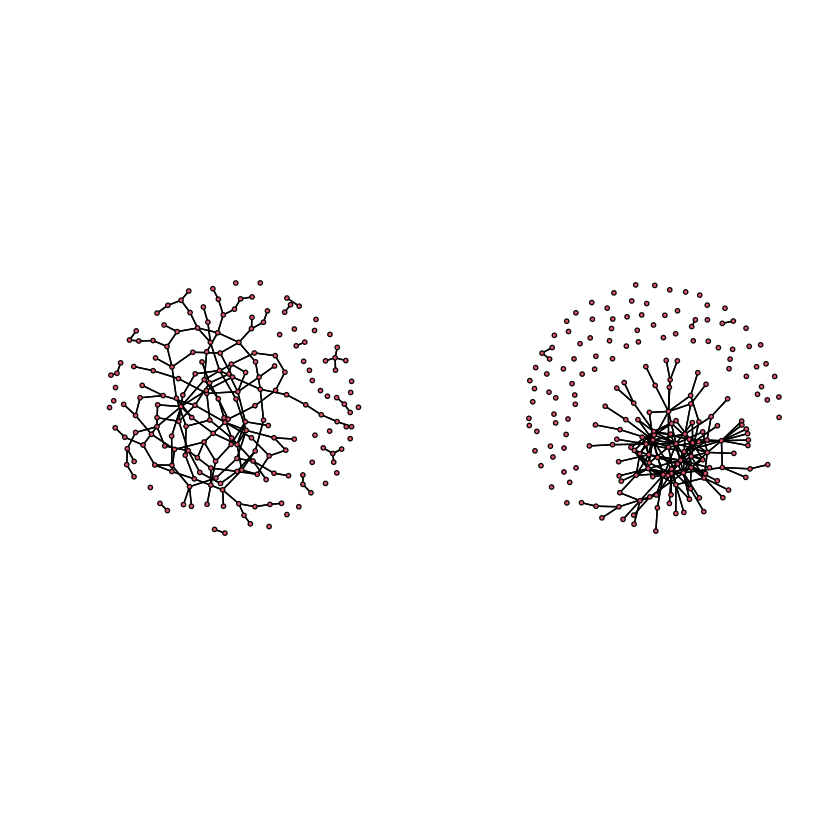

In [7]:
Xbern <- rgraph(n,tprob=tie.prob, mode='graph')
Xergm <- as.matrix( simulate( as.network(Xbern,directed=FALSE)~ kstar(2:3)+triangle,
                         coef=c(star.coef,star.coef.3,coef.triangle),
                         constraints=~edges,# this is what does it degreedist is based on padgbus.net
                         nsim=1,
                         control=control.simulate(MCMC.burnin=100000) ) )  
par(mfrow=c(1,2))
gplot(Xbern, gmode='graph')
gplot(Xergm, gmode='graph')

Note, that while the two networks will have identical density, the proportion of closed triangles will be completely different


In [8]:
gtrans(Xbern)
gtrans(Xergm)


[1] 0

[1] 0.1060172

The degree distributions are radically different but the while there are some big hubs in the ERGM there are also lots of isolates, in fact, the majority of nodes are isolates.

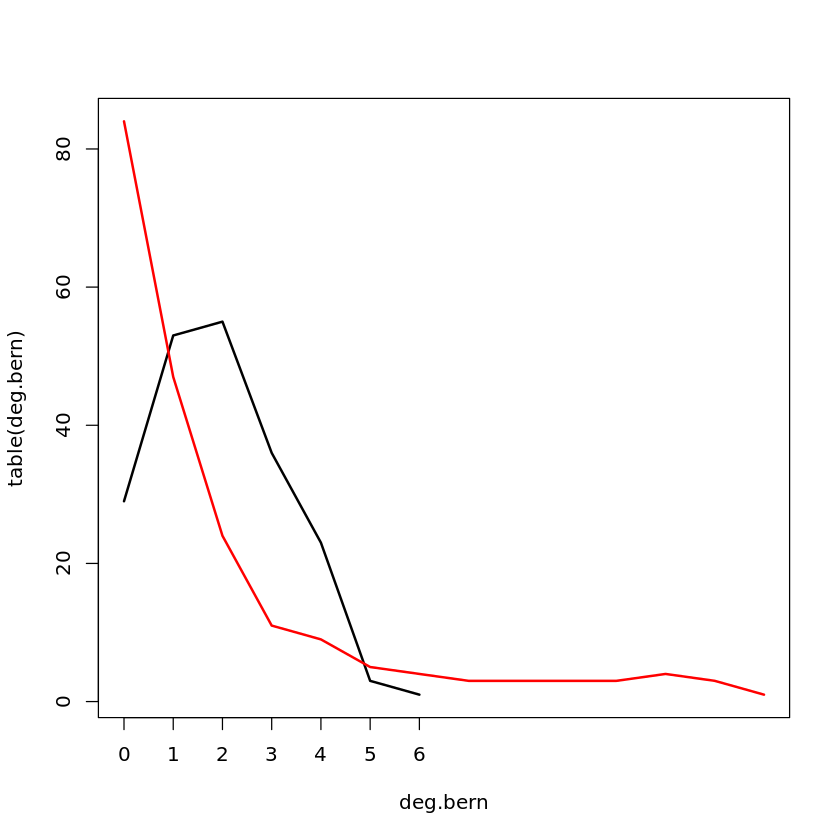

In [9]:
deg.bern <- degree(Xbern, gmode='graph')
deg.ergm <- degree(Xergm, gmode='graph')
plot(table(deg.bern),type='l',ylim= range(table(deg.bern),table(deg.ergm) ), xlim=range(deg.bern,deg.ergm) )
lines(table(deg.ergm),type='l', col='red')

The geodesic distances are generally *shorter* in the ERGM

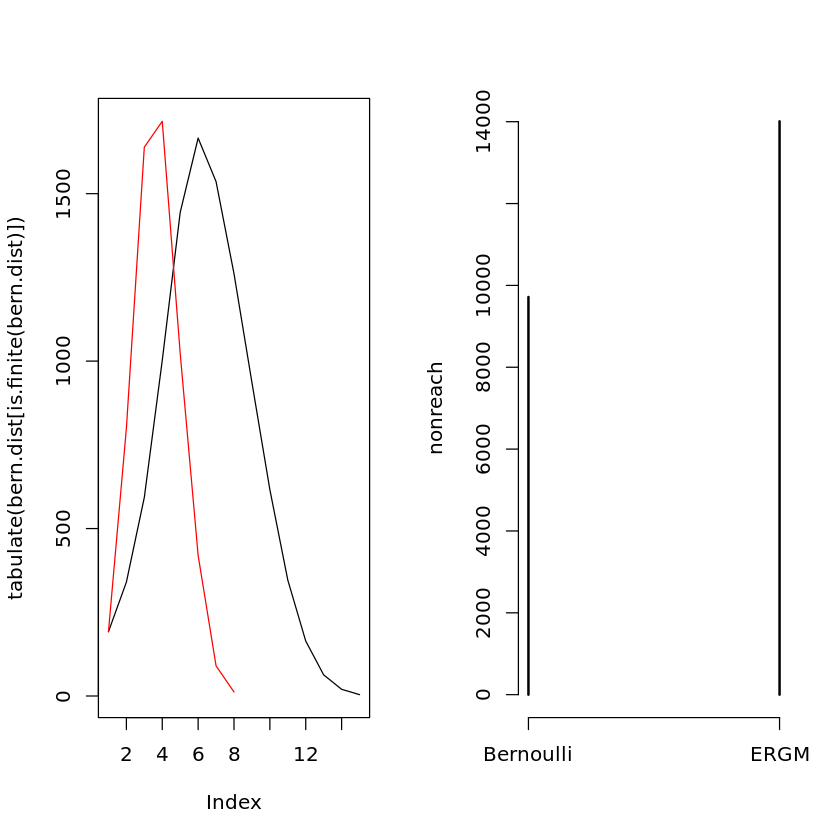

In [10]:
bern.dist <- geodist( Xbern )$gdist # calculate the pair-wise distances between nodes in Bernoulli graph
bern.dist <- bern.dist[upper.tri(bern.dist)]# use only the unique, unordered pairs
not.reach.bern <- sum(!is.finite(bern.dist)) # what is the number of pairs that are unreachable?
ergm.dist <- geodist( Xergm )$gdist # now, calcuate the same things for the ERG
ergm.dist <- ergm.dist[upper.tri(ergm.dist)]
not.reach.ergm <- sum(!is.finite(ergm.dist ))

par( mfrow=c(1,2))
plot(tabulate( bern.dist[is.finite(bern.dist)] ) , 
     ylim=range(tabulate( bern.dist[is.finite(bern.dist)] ), tabulate( ergm.dist[is.finite(ergm.dist)]  ) ),type='l' ) 
lines( tabulate( ergm.dist[is.finite(ergm.dist)]  ) ,col='red' )

nonreach <- as.table( c(not.reach.bern,not.reach.ergm))
names(nonreach ) <- c('Bernoulli','ERGM')
plot(nonreach)

But, this is only conditional on pairs of nodes that are connected and since the ERGM has a large number of isolates, the right-hand panel shows that about twice as many pairs in the ERGM relative to the random graph are not reachable.

This brings into question what exactly we mean by *small world networks*. An excellent treatment of how ERGM can be used to model small-worldiness is provided by Robins et al. (2005).

## The exposure term
The rate at which you become infected if you have $d=1,2,3\ldots$ neighbours and $k=1,2,\ldots,k$ of them are infected relative to none of them being infected, for total exposure, and average exposure

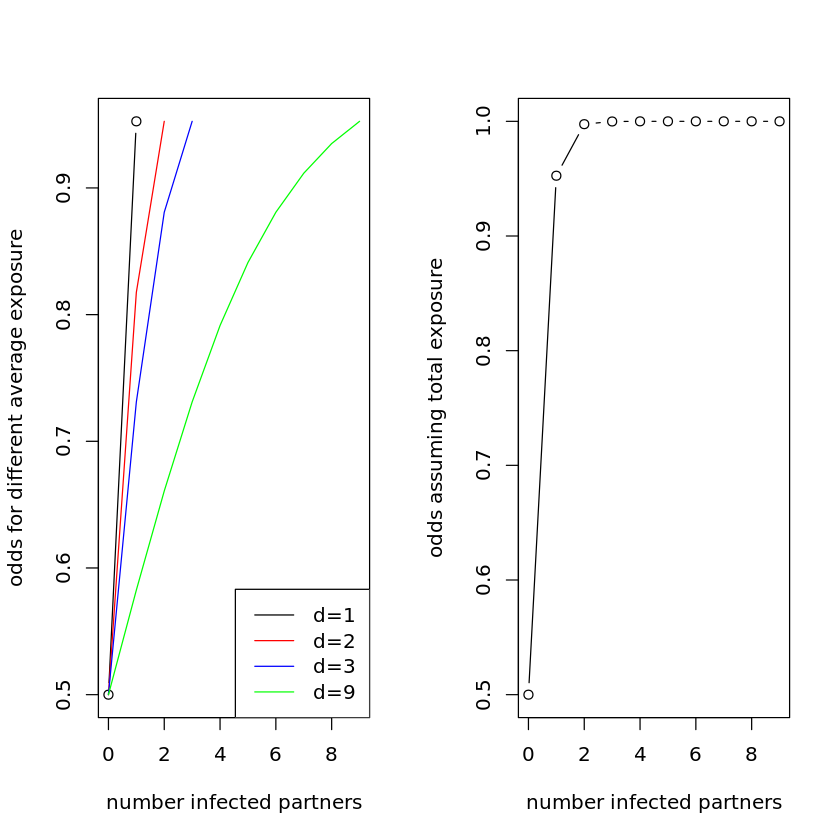

In [11]:
alpha <- -3
beta <- 3
d<- 1
yrange <- c(0.5,exp(beta*9/9)/(1+exp(beta*9/9) ) )
par(mfrow=c(1,2))
plot( c(0:d),exp(alpha+beta*c(0:d)/d)/(exp(alpha)+exp(alpha+beta*c(0:d)/d)) ,
      xlim=c(0,9) ,
      ylim=yrange ,type='b',
      xlab='number infected partners',ylab='odds for different average exposure')
d<- 2
lines( c(0:d),exp(alpha+beta*c(0:d)/d)/(exp(alpha)+exp(alpha+beta*c(0:d)/d)),col='red' )
d<- 3
lines( c(0:d),exp(alpha+beta*c(0:d)/d)/(exp(alpha)+exp(alpha+beta*c(0:d)/d)), col='blue' )
d<- 9
lines( c(0:d),exp(alpha+beta*c(0:d)/d)/(exp(alpha)+exp(alpha+beta*c(0:d)/d)) ,col='green')
d<- 9
yrange <- c(0.5,exp(beta*9)/(1+exp(beta*9) ))
legend('bottomright',col=c('black','red','blue','green' ),
       legend=c('d=1','d=2','d=3','d=9'), lty =c(1,1,1,1))

plot( c(0:d),exp(alpha+beta*c(0:d))/(exp(alpha)+exp(alpha+beta*c(0:d))) ,xlim=c(0,9) ,ylim=yrange ,type='b',
      xlab = 'number infected partners',ylab='odds assuming total exposure')


This can be understood as comparing the probability of $i$ being the winner out of $i$ and $j$
$$
\Pr(T_i <T_j) =\frac{\lambda_i}{\lambda_i+\lambda_j}
$$


In terms of waiting times, we can plot the times until effected under total exposure


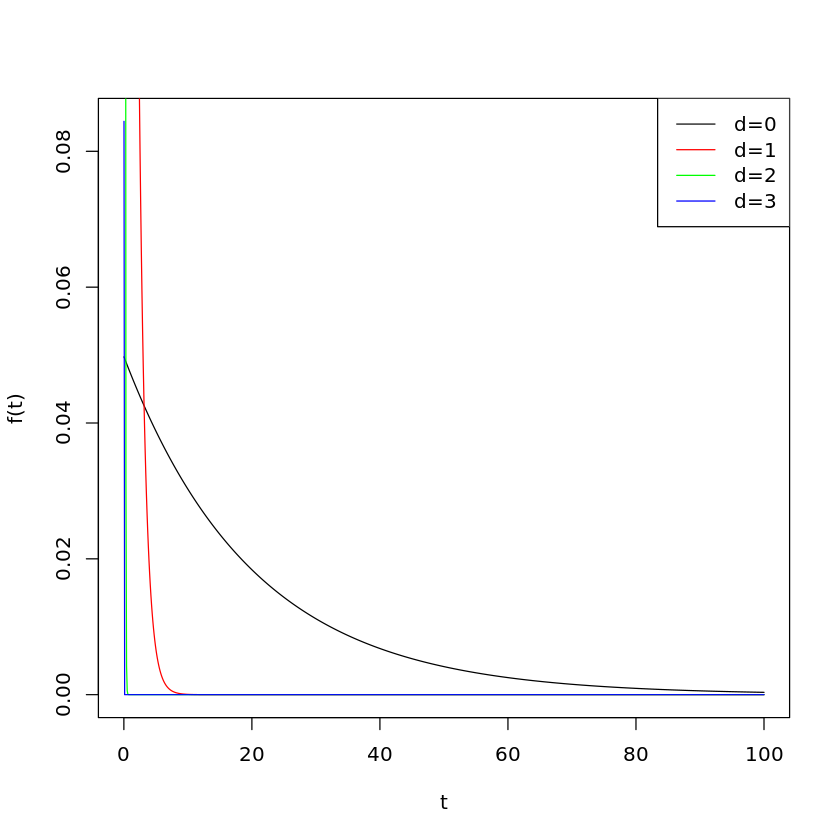

In [12]:
x.ax <- seq(0.021,100, length.out=1000)
plot(x.ax , dexp(x.ax ,exp(alpha)),
     type='l',xlab='t',ylab='f(t)',
     ylim=range( dexp(x.ax ,exp(alpha)),
                 dexp(x.ax , exp(alpha+beta*3) ) ) )
lines( x.ax , dexp(x.ax ,exp(alpha+beta*1)),col='red')
lines( x.ax , dexp(x.ax ,exp(alpha+beta*2)),col='green')
lines( x.ax , dexp(x.ax ,exp(alpha+beta*3)),col='blue')
legend('topright',col=c('black','red','green','blue' ),
       legend=c('d=0','d=1','d=2','d=3'), lty =c(1,1,1,1))

## Simulate adoption
Define a function that simulates the diffusion process/spread on $X$, with paramters $\alpha$ and $\beta$, for a given number of initial first movers

In [13]:
get.epidemic <- function(X,alpha,beta,seed.size=10){
n <- dim(X)[1]
Y <- matrix(0, n,1)

Y[sample(c(1:n) , size = seed.size )] <- 1 # random seeds
Nsims <- n-seed.size# number left to infect
time.axes <- matrix(0,Nsims,1)
infection.status <- matrix(0,n,Nsims)
infection.status[Y==1,1] <- 1

t <- 0

for (k in c(2:Nsims) ){
all.rates <- increment.time(Y,X,beta,alpha)
if (any(!is.na(all.rates) ) )# check if there is anyone left to infect
{
prob <- all.rates/sum(all.rates, na.rm=TRUE)# lambda_i/sum lambda_j
prob[is.na(prob)] <- 0# if your rate is NA, that is because you have already adopted/gotten infected
changeling <- sample(c(1:n),size=1 , prob = prob)# draw the node that is adopting (using probs lambda_i/sum lambda_j)
Y[ changeling ] <- 1# set the infection status/innovation status of the changer
infection.status[,k] <- Y# store current state
big.rate <- sum( all.rates , na.rm = TRUE)# calculate the rate of the shortes t waiting time
t <- t + rexp(1,rate=big.rate)# increment time with the shortest waiting time
time.axes[k] <- t
}
}

outbreak <- list( time.axes = time.axes, infect = colSums(infection.status) )
outbreak
}

## Run epidemic
Simulate the diffusion/epidemic for 20 populations, half of which have a Bernoulli network, and half have an ERG as their population network.



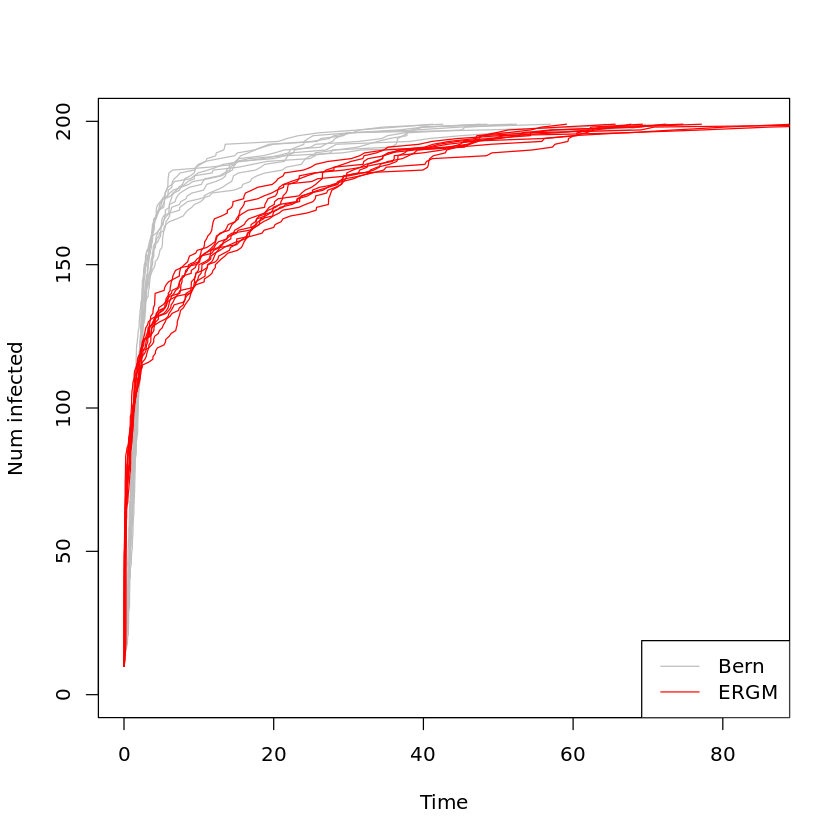

In [14]:
num.edges <- sum(Xbern)/2

for (k in c(1:20))
{
  if (k <11){
  X <- rgnm(n=1,nv=n,m=num.edges ,mode='graph')# Simulate a population Bernoulli graph
   usecol <-  'grey'
  }
  if (k >= 11){
    X <- as.matrix( simulate( as.network(X,directed=FALSE)~ kstar(2:3)+triangle,
                         coef=c(star.coef,star.coef.3,coef.triangle),
                         constraints=~edges,# this is what does it degreedist is based on padgbus.net
                         nsim=1,
                         control=control.simulate(MCMC.burnin=100000) ) )  # ERGM population graph
    usecol <-  'red'
  }
  outbreak <- get.epidemic(X,alpha,beta)
  if (k==1)
  {
    plot( outbreak$time.axes,outbreak$infect, type ='l',ylim=c(0,n),xlim=c(0,max(outbreak$time.axes)*1.5) ,
          xlab='Time',ylab='Num infected' , col=usecol)
  }
  if (k %in% c(2:20))
  {
  lines(outbreak$time.axes,outbreak$infect, col=usecol)
  }
}
legend( 'bottomright', col=c('grey','red') , lty=c(1,1) , legend = c('Bern','ERGM') )


#### Question 1

Is there a qualitative difference between the same process on the two different networks and, if so, how would you explain it (*Hint*: How much bigger is the 'main' component of the Bernoulli network compared to the ERG)?

YOUR ANSWER HERE

## Micro-macro
Here we see an example where have the combination of two micro-level processess aggregating up to the population level. The first is the network formation - in one case random and in the other dependent on the local neighbourhood of nodes. The second process is the adoption process. We can tweak both. The latter for example, can be used with `exposure` set to `ave` instead of `tota`. To more closely reflect a strictly contagious desease, we can make adoption/infection only possible if neighbourning nodes have adopted/are infected setting `contact` to `strict` rather than `free`.


![The interplay of micro and macro](micromacro.png)

The network formation here can be considered local and the two different network tie-formation principles aggregate up to different global patterns. In the ERGM, if we think of tie-formation as a local tie-based process, the presence of ties will affect the existence of other ties, hence the network structure is a constraint on itself. When the local adoption process is carried out in two different structures, the population outcome is different.


# Network regression

## Load data
We are looking at the s50 dataset, which is further described here: <https://www.stats.ox.ac.uk/~snijders/siena/s50_data.htm>

This dataset is available in ziped format online.


In [15]:
temp <- tempfile()
download.file("https://www.stats.ox.ac.uk/~snijders/siena/s50_data.zip",temp)
X <- as.matrix( read.table(unz(temp, "s50-network1.dat")) )
sport <- read.table(unz(temp, "s50-sport.dat"))
smoke <- read.table(unz(temp, "s50-smoke.dat"))
alcohol <- read.table(unz(temp, "s50-alcohol.dat"))
unlink(temp)
n <- nrow(X)
smoke <- (smoke[,2] %in% c(2,3))+0 # use wave 2 and set values of 2 and 3 to smoking and 1 to non-smoking
sport <- sport[,1]-1# dichotomise sporty

## Overall task
The variable Alcohol use is coded as

Alcohol value | meaning 
:--------: | :------: 
 1 | non
 2 | once or twice a year
 3 | once a month 
 4 | once a week
 5 | more than once a week
 
We are now going to investigate if your friends alcohol use tends to influence your alcohol use. Start with plotting the networks with

* Node size proportional to alcohol use
* Colour by red for smoker, 1 (previous values: 2-3), and green for non-smoker 0 (origal value: 1)


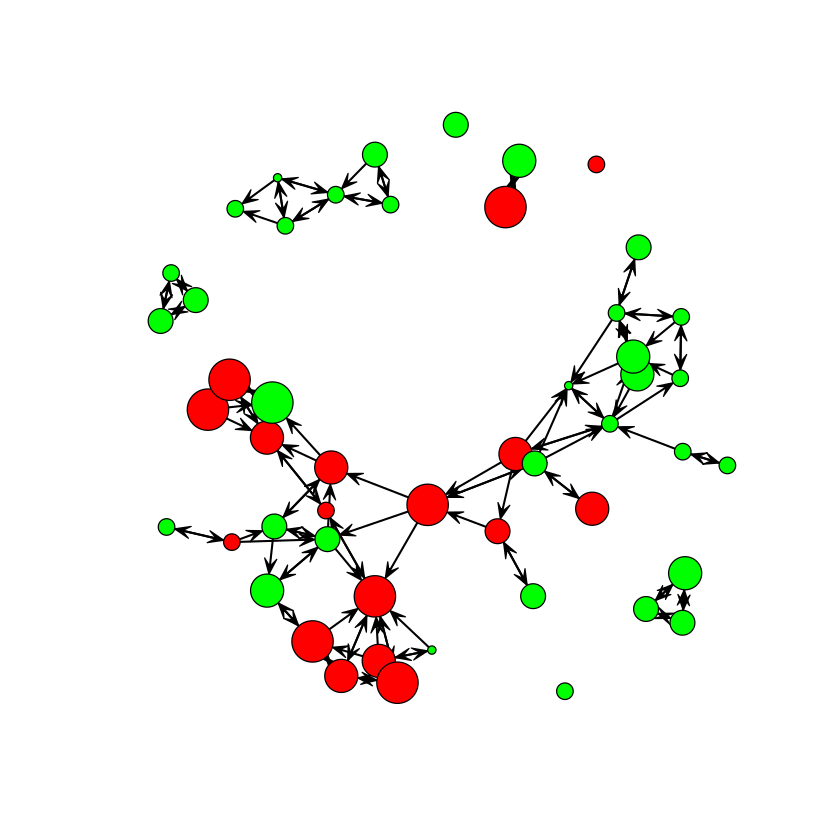

In [16]:
gplot(X,vertex.cex=alcohol[,2]/2, vertex.col = ifelse(smoke==1,'red','green') )

#### Question 2
Looking at the figure, do you see any evidence of *social influence*?

YOUR ANSWER HERE

# Ordinary least squares (OLS) regression
Make the assumption that the levels of smoking can be treated as a interval-level, continuous variable. To model the outcomes, we start with assuming that outcomes are independent across students using a regression model

$$
Y_i = \beta_0+\beta_1 m_{i,smoke} + \beta_2 m_{i,sport}+\epsilon_i
$$
where 
* $\beta_0$ is the intercept
* $\beta_1$ is the average difference in alcohol use for smokers relative to non-smokers 
* $\beta_2$ is the average difference in alcohol use for sporty people relative to non-sporty people 

and the $\epsilon_i$'s are assumed to be **independent** across $i$ and follow a normal distribution $N(0,\sigma^2)$.

## Fit OLS


In [ ]:
y <- alcohol[,2]
ans.ols <- lm(y ~ smoke+sport)
summary(ans.ols)

#### Question 3

What conclusions can you draw from the ANOVA table of the OLS regression regarding the regressors smoke and sport?

YOUR ANSWER HERE

### Residuals
We assumed that the errors were normally distributed so the residuals 

$$
\hat{e}_i= y_i - \hat{y}_i= y_i - \hat{\beta}M_i^{\top}
$$

should be normally distributed:

In [ ]:
hist(ans.ols$residuals)

> The residuals seem reasonably 'normal'

### Autocorrelation
We are now going to investigate other properties of the model.

For the `sna` package, we need to put all covariates, including the constant, in a matrix

$$
M = \begin{pmatrix}
M_{1}\\
M_{2}\\
\vdots\\
M_{n}\\
\end{pmatrix}= \begin{pmatrix}
1 & m_{1,1} & \cdots & m_{Z,p}\\
1 & m_{2,1} & \cdots & m_{Z,p}\\
\vdots & \vdots & \vdots& \vdots\\
1 & m_{n,1} & \cdots & m_{n,p}\\
\end{pmatrix}
$$

We thus put all covariates into the same matrix:

In [ ]:
M <- cbind(matrix(1,n,1),smoke,sport)
colnames(M) <- c('cons','smoke','sport')
head(M)

Let us investigate whether the residuals are independent across the network. In particular, if the outcome of $i$ is completely independent of the outcome of $j$ then we would not expect there to be a difference between $(\hat{e}_i - \bar{e})(\hat{e}_j-\bar{e})$ for a pair that is connected through a ties $x_{ij}=1$ and a pair  $(\hat{e}_i - \bar{e})(\hat{e}_k-\bar{e})$ that is not connected, $x_{ik}=0$. In other words, higher (lower) than predicted values should not be expected if a network partner has higher (lower) than predicted value. Note that the average $\bar{e}=0$ by construction and was just included for clarity. Moran's I does measure exactly whether connected partners tend to have more similar residuals than unconnected people. In terms of the outcome variable

$$
I_k =\frac{n}{\sum_{i=1}^n\sum_{j=1}^n X_{ij}^{(k)}} \frac{\sum_{i=1}^n \sum_{j=1}^n (y_i-\bar{y}) (y_j-\bar{y})X_{ij}^{(k)} }{\sum_{j=1}^n (y_j-\bar{y})^2}
$$

Where $X_{ij}^{(k)}$ is the $k$-step adjacency matrix, i.e. $X_{ij}^{(1)}$ is the matrix of people that are directly connected,  $X_{ij}^{(2)}$ is the matrix of people that are connected at distance 2, etc. The step $k$ is sometimes called *lag*. Intuitively, if $X_{ij}^{(k)}$ doesn't matter, then many cross-product terms should cancel others out. It can be shown that, under the assumption that there is no network correlation at lag $k=1$, then the expected value is

$$
E(I_1) = \frac{-1}{N-1}
$$

Here we want to check if this seems to hold true for our residuals - are they uncorrelated across network partners?


In [ ]:
round(nacf(X,ans.ols$residuals,type="moran"),3 )
# nacf(X,ans.ols$residuals,type="geary") # Geary's C is another measure of autocorrelation but is harder to undertand

#### Question 4
What does it mean that $I_0=1$?

YOUR ANSWER HERE

We are only really interested in shorter lags, so let us plot the first 4 and add a reference line for $E(I_1)$ under no correlation




In [ ]:
plot(nacf(X,ans.ols$residuals,type="moran")[1:4],type='b')
abline(h=-1/(n-1),col='red')


## Row-nomalise
When modelling social influence we may want scale the network ties to take into account how many ties people have. Leenders (2002) propose a number of ways in which we can scale the adjacency matrix. Here we want each arc to have the weight

$$
W_{ij} = X_{ij}/d_{i,out}
$$
We can do this easily BUT we have to be careful so that we do not divide by 0 (we define $0/0$ as $0$)


In [ ]:
degrees <- degree(X,outdegree)
W <- X
W[degrees>0,] <- X[degrees>0,]/degrees[degrees>0]

# You can check that we are actually normalising correctly
# Wcopy <- X
# for (i in c(1:n))
# {
#  if (degrees[i]>0)
#  {
#    Wcopy[i,] <- X[i,]/degrees[i]
#  }
#  
#}
#sum( W != Wcopy)

## Check residuals again
Check the residuals again

In [ ]:
plot(nacf(W,ans.ols$residuals,type="moran")[1:4],type='b')

Do we see any difference? In the formula for $I_k$ the scaling factors $d_i$ will actually cancel out.

## Network autocorrelation model
The *network autocorrelation* model, or *network disturbances* model, looks exactly like the OLS
$$
y_i = M_i \beta + \epsilon_i\text{,}
$$
but we no longer assume that the residuals are *independent*. Instead, we induce network autoocorrelation on the error terms

$$
\epsilon_i = \rho \sum_{j=1}^n W_{ij}\epsilon_j+\xi_i
$$
($\xi$ is the Greek letter Xi - <https://en.wikipedia.org/wiki/Xi_(letter)>), where $\rho$ is the autocorrelation parameter. The error tems $\xi_i$ are assumed to be independent and identically distributed $\xi_i \thicksim N(0,\sigma^2)$. The interpretation is that if $i$ has a higher than predicted value on the outcome variable then $j$ is more likely to *also* have higher than predicted values for all $j$ that $i$ has nominated.

If you know a bit of matrix algebra, you will notice that we can write the vector of disturbances $\epsilon = (\epsilon_1,\ldots,\epsilon_n)^{\top} $ as
$$
\epsilon = \rho W \epsilon + \xi
$$

One immediate issue here is that we have $\epsilon$ on both sides of the equation. We can simplify this expression by solving for $\epsilon$
$$
\epsilon = (I-\rho W)^{-1}\xi
$$

You can intepret this as the error terms $\xi_i$ 'spreading' on the network.

### Fir the network autocorrelation model

The function `lnam` (which stands for linear network autocorrelation models, pressumably) can fit this model. The formula is specified in terms of the outcome `y` variable and the matrix `x` of covariates. The weight matrix is specified as `W2`.


In [ ]:
netacm.1 <-lnam(y=y, x=M, W2=W)
summary(netacm.1)

#### Question 5
Did the conclusions about the regressors smoke and sport change?

YOUR ANSWER HERE

#### Question 6
Is there evidence of network autocorrelation?

YOUR ANSWER HERE

Looking at the network plot, it almost looks as if high-degree nodes drink more. To take this into account, we add outdegree as an explanatory variable:

In [ ]:
M <- cbind(matrix(1,n,1),degrees,smoke,sport )
colnames(M) <- c('cons','degree','smoke','sport')
head(M)

Now re-run the network autocorrlation model (call the output `netacm.2` to align with the code in the code chunk below)

In [ ]:
# YOUR CODE HERE
stop('No Answer Given!')
summary(netacm.2)

#### Question 7
Did accounting for outdegree change the conclusions about network autocorrelation?

YOUR ANSWER HERE

### Network Effects model
The *network effects* model assumes that there is *correlation through the outcome variable* $Y$. This subtly different from correlation only through the error term. The outcome $Y_i$ for $i$ is a a weighted sum of the values $Y_j$ of the contacts of $i$
$$
Y_i = \rho \sum_{j=1}^n W_{ij}Y_i + M_i\beta+\epsilon_i
$$
where $\epsilon_i \thicksim N(0,\sigma^2)$ independently for all $i$. 

> If you want to model social influence or social contagion, the network effects model is more approprate than the autocorrelation model as the former models the dependence between values on the outcome varaible

The equation for the full outcome vector can, as before, be written compactly as

$$
Y = \rho W Y + M\beta+\epsilon
$$

Here it is there is *feedback* on the outcome variable.

### Stationary distribution
We can derive this model out of a longitudinal model

$$
Y_{i,t} = \rho \sum_{j=1}^n W_{ij}Y_{j,t-1}+M\beta+\epsilon_{i,t}
$$
as $t$ tends to infinity.

For a quick illustration, let us look at the first 5 interaction of the updating accourding to the longitudinal form of the model

In [ ]:

rho <- 0.4# set a strong influence paramter
beta <- matrix(summary(netacm.2)$beta[,1],4,1)# use the estimated coefficients from the last regression
Y <- matrix(rnorm(n),n,1)# random starting point
par(mfrow=c(2,3), oma = c(0,1,0,0) + 0.1,mar = c(1,0,1,1) + 0.1)
coord <- gplot(X,gmode='graph',vertex.cex = Y/2,main= paste('M ',round(nacf(W,Y[,1],type="moran")[2],3) ) )
for (k in c(1:5)){
Y <- rho * W %*% Y + M %*% beta + matrix(rnorm(n),n,1)# update Y according to equation; %*% for matrix multiplication
gplot(X,gmode='graph',vertex.cex = Y/2, coord=coord, main= paste('M ',round(nacf(W,Y[,1],type="moran")[2],3) ) )
}

We may or may not see increased corrlation in the outcomes. Running 100 iterations this will become a little more evident


In [ ]:
moran <- matrix(0,100,3)
rho <- .4
Y <- matrix(rnorm(n),n,1)
for (k in c(1:100)){
Y <- rho * W %*% Y + M %*% beta + matrix(rnorm(n),n,1)
moran[k,] <- nacf(W,Y[,1],type="moran")[2:4]}
par(mfrow=c(1,1))
plot(moran[,1],type='l')
lines(moran[,2],col='red')
#lines(moran[,3],col='blue')
abline( h = -1/(n-1), col='grey')

We might see a slight trend upwards and correlations are generally speaking positive.

As before $Y$ on both sides of the equation, but we can solve for $Y$
$$
Y = (I- \rho W)^{-1}(M\beta+\epsilon)
$$

The same function as before, `lnam` is used to fit this model. The difference from the network autocorrelation model is that the weight matrix is specified as `W1` *not* `W2`.

In [ ]:
neteff.2 <-lnam(y=y, x=M, W1=W)
summary(neteff.2)

#### Question 8

Is there any evidence for social influence on alcohol?

YOUR ANSWER HERE

## Simplify model

Fit a regression that only includes (the intercept) smoke and that uses the original, non-normalised, adjacency matrix


In [ ]:
# YOUR CODE HERE
stop('No Answer Given!')
summary(neteff.2)# assuming you called your estimation object 'neteff.2'

#### Question 9
What do you conclude from the results? Can you relate this to total and average exposure in the diffusion model?

YOUR ANSWER HERE

# References

Greenan, Charlotte C. 2015. “Diffusion of Innovations in Dynamic Networks.” Journal of the Royal Statistical Society. Series A (Statistics in Society). JSTOR, 147–66.

Myers, Daniel J. 2000. “The Diffusion of Collective Violence: Infectiousness, Susceptibility, and Mass Media Networks.” American Journal of Sociology 106 (1). The University of Chicago Press: 173–208.

Leenders, R. T. A. (2002). Modeling social influence through network autocorrelation: constructing the weight matrix. Social networks, 24(1), 21-47.

Robins, Garry, Philippa Pattison, and Jodie Woolcock. 2005. “Small and Other Worlds: Global Network Structures from Local Processes.” American Journal of Sociology 110 (4). The University of Chicago Press: 894–936.

Strang, David, and Nancy Brandon Tuma. 1993. “Spatial and Temporal Heterogeneity in Diffusion.” American Journal of Sociology 99 (3). University of Chicago Press: 614–39.

Valente, Thomas W. 2005. “Network Models and Methods for Studying the Diffusion of Innovations.” Models and Methods in Social Network Analysis 28. Cambridge University Press New York, NY: 98–116.
